<a href="https://colab.research.google.com/github/saniyaverma/Crop-Disease-Prediction-Models-analysis/blob/v1/Tomato_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlexNet

In [ ]:
import numpy as np
import os
import json
from zipfile import ZipFile
import shutil
from PIL import Image
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

from tensorflow.keras import Model, callbacks, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML

In [ ]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# Load Kaggle credentials and download dataset
kaggle_credentials = json.load(open("kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

!kaggle datasets download -d kaustubhb999/tomatoleaf

# Unzip
with ZipFile("tomatoleaf.zip", 'r') as zip_ref:
    zip_ref.extractall()

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
 67% 120M/179M [00:00<00:00, 1.25GB/s]
100% 179M/179M [00:00<00:00, 1.07GB/s]


In [ ]:
# Paths from the dataset
train_path = "/content/tomato/train"
val_path = "/content/tomato/val"

**Create a unified folder**

In [ ]:
# New unified folder
combined_path = "/content/tomato-leaf-disease"
os.makedirs(combined_path, exist_ok=True)

def combine_folders(source_dir, target_dir):
    for cls in os.listdir(source_dir):
        src_cls_path = os.path.join(source_dir, cls)
        dst_cls_path = os.path.join(target_dir, cls)
        os.makedirs(dst_cls_path, exist_ok=True)

        for file_name in os.listdir(src_cls_path):
            src_file = os.path.join(src_cls_path, file_name)
            dst_file = os.path.join(dst_cls_path, file_name)

            # Only copy if file doesn't already exist
            if not os.path.exists(dst_file):
                shutil.copy2(src_file, dst_file)

        print(f"Copied: {cls} from {source_dir} to {target_dir}")

# Combine all splits into one
combine_folders(train_path, combined_path)
combine_folders(val_path, combined_path)

Copied: Tomato___Spider_mites Two-spotted_spider_mite from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Target_Spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Tomato_mosaic_virus from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Late_blight from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___healthy from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Leaf_Mold from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Early_blight from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Tomato_Yellow_Leaf_Curl_Virus from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Bacterial_spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Septoria_leaf_spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Spider_mites Two-spotted_spider_mite from /cont

**Check for total image count**

In [ ]:
def count_images_in_folders(folder_path):
    total_images = 0
    print(f"\nChecking folder: {folder_path}")
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            total_images += count
            print(f"{cls}: {count} images")
    print(f"\nTotal images: {total_images}")

# Run this:
count_images_in_folders("/content/tomato-leaf-disease")


Checking folder: /content/tomato-leaf-disease
Tomato___Bacterial_spot: 1100 images
Tomato___Early_blight: 1100 images
Tomato___Late_blight: 1100 images
Tomato___Leaf_Mold: 1100 images
Tomato___Septoria_leaf_spot: 1100 images
Tomato___Spider_mites Two-spotted_spider_mite: 1100 images
Tomato___Target_Spot: 1100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1100 images
Tomato___Tomato_mosaic_virus: 1100 images
Tomato___healthy: 1100 images

Total images: 11000


**Check for Corrupt or Unreadable Images**

In [ ]:
def check_image_integrity(folder_path):
    broken = []
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        for img_file in os.listdir(cls_path):
            try:
                img_path = os.path.join(cls_path, img_file)
                with Image.open(img_path) as img:
                    img.verify()
            except Exception as e:
                broken.append(img_path)
                print(f"Corrupt: {img_path} — {e}")
    if not broken:
        print("All images verified successfully.")
    else:
        print(f"Found {len(broken)} corrupt images.")

check_image_integrity("/content/tomato-leaf-disease")


All images verified successfully.


Set the constants

In [ ]:
IMAGE_SIZE = 227
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 30

**Import data into tensorflow dataset object**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato-leaf-disease",
    seed=123,
    shuffle=True,
    image_size=(227,227),
    batch_size=BATCH_SIZE
)

Found 11000 files belonging to 10 classes.


In [ ]:
class_names = dataset.class_names
# num_classes = len(class_names)
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

**Visualize some of the images from our dataset**

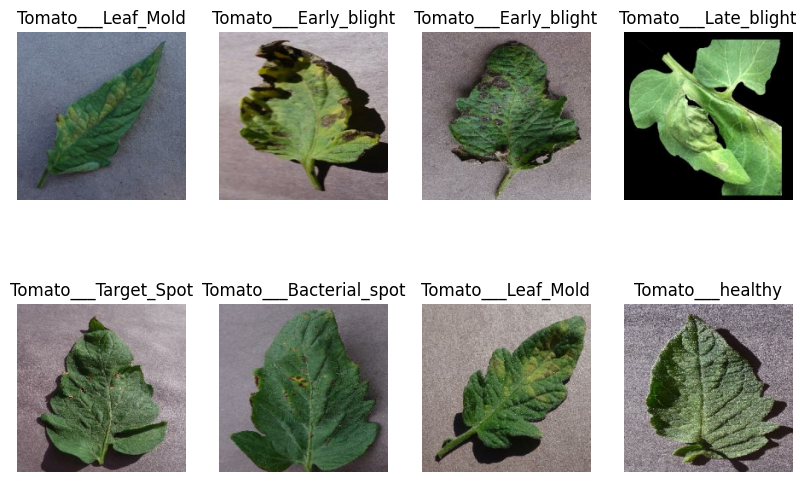

In [ ]:
plt.figure(figsize=(10, 10))

# Take one batch (usually of 8 images) from the dataset
for image_batch, labels_batch in dataset.take(1):

    # Loop through all the images in the batch
    for i in range(BATCH_SIZE):

        # Create a subplot in a 3x4 grid (3 rows, 4 columns)
        ax = plt.subplot(3, 4, i + 1)

        # Convert the images in the batch to a NumPy array and display it
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # .astype("uint8") ensures correct color format

        # Convert the label tensor to a NumPy integer, use it to get the class name, and set as title
        plt.title(class_names[labels_batch[i]])

        # Turn off the axis ticks and grid for cleaner display
        plt.axis("off")

**Splitting the dataset**

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=123)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds)

1100

In [ ]:
len(val_ds)

137

In [ ]:
len(test_ds)

138

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

**Preprocessing the Data**

**Resizing & Rescaling**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

**Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
# Train: resize → augment → prefetch
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Val/test: resize → prefetch (no augmentation)
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers, optimizers

In [ ]:
# Instantiate model
model = tf.keras.models.Sequential(name="Alexnet")

model.add(layers.Conv2D(96, (11,11), strides=(4,4), padding='valid',
                        kernel_regularizer=regularizers.l2(0.001), input_shape=(227,227,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (5,5), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(384, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(384, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))  # Corrected to 10 classes

model.summary()

# Compile
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Alexnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,720,842 (52.34 MB)

 Trainable params: 13,718,090 (52.33 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_ckpt = callbacks.ModelCheckpoint(
    filepath="best_alexnet.h5",  # or best_alexnet.keras if using latest version
    save_best_only=True,
    monitor="val_loss"
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 109s 72ms/step - accuracy: 0.1521 - loss: 9.0756 - val_accuracy: 0.2728 - val_loss: 2.7006 - learning_rate: 0.0010
Epoch 2/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 97s 78ms/step - accuracy: 0.2156 - loss: 2.8120 - val_accuracy: 0.1533 - val_loss: 2.4536 - learning_rate: 0.0010
Epoch 3/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 130s 69ms/step - accuracy: 0.2065 - loss: 2.4062 - val_accuracy: 0.3057 - val_loss: 1.9226 - learning_rate: 0.0010
Epoch 4/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.2041 - loss: 2.2698 - val_accuracy: 0.2591 - val_loss: 2.1828 - learning_rate: 0.0010
Epoch 5/20
1099/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2211 - loss: 2.2090
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.2211 - loss: 2.2092 - val_accuracy: 0.1697 - val_loss: 2.7103 - learning_rate: 0.0010
Epoch 6/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 85s 69ms/step - accur

In [ ]:
initial_epochs = 20
new_epochs = 10
total_epochs = initial_epochs + new_epochs

In [ ]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 20/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.7026 - loss: 0.9511 - val_accuracy: 0.8075 - val_loss: 0.6725 - learning_rate: 4.0000e-05
Epoch 21/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 144s 70ms/step - accuracy: 0.7357 - loss: 0.8878 - val_accuracy: 0.7765 - val_loss: 0.6524 - learning_rate: 4.0000e-05
Epoch 22/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 85s 69ms/step - accuracy: 0.7359 - loss: 0.8686 - val_accuracy: 0.8276 - val_loss: 0.6142 - learning_rate: 4.0000e-05
Epoch 23/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - accuracy: 0.7479 - loss: 0.8246 - val_accuracy: 0.8376 - val_loss: 0.5691 - learning_rate: 4.0000e-05
Epoch 24/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 93s 76ms/step - accuracy: 0.7600 - loss: 0.7979 - val_accuracy: 0.8038 - val_loss: 0.5879 - learning_rate: 4.0000e-05
Epoch 25/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.7772 - loss: 0.7784 - val_accuracy: 0.8431 - val_loss: 0.5549 - learning_rate: 4.0000e-05
Epoch 26/30
1100/1100 ━━━━━━━━━━━

In [ ]:
acc = history.history['accuracy'] +history_1.history['accuracy']
val_acc = history.history['val_accuracy'] +  history_1.history['val_accuracy']

loss = history.history['loss'] + history_1.history['loss']
val_loss = history.history['val_loss'] +  history_1.history['val_loss']

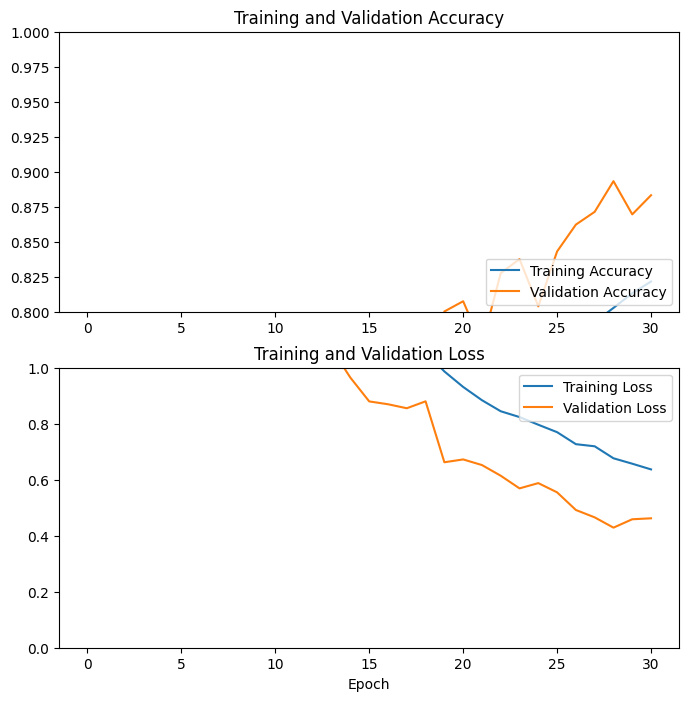

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

first image to print


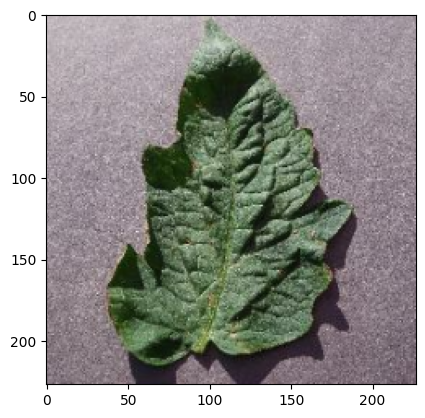

first image actual label: Tomato___Target_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Tomato___Target_Spot


In [ ]:
for image_batch, label_batch in val_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to print")
    plt.imshow(first_image)
    plt.show()

    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


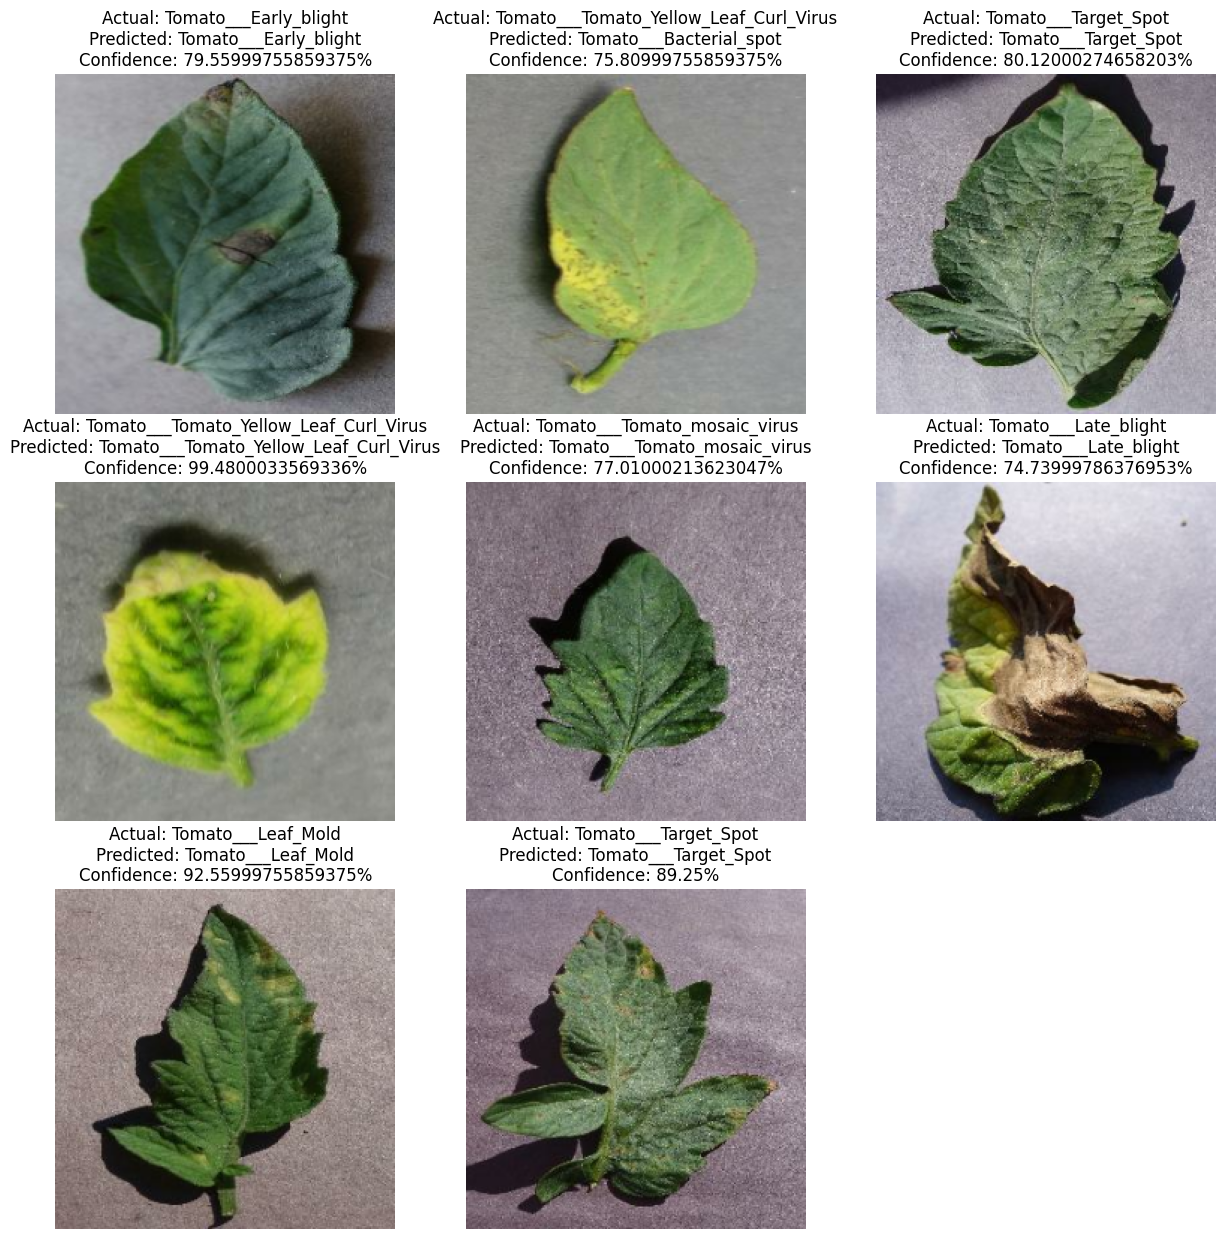

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in val_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

**Model Predictions**

In [ ]:
y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()             # shape (batch_size,)


    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

**Accuracy**

In [ ]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 88.41%


**Precision**

In [ ]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'
print(f"Precision: {precision * 100:.2f}%")

Precision: 88.71%


**Recall**

In [ ]:
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall * 100:.2f}%")

Recall: 88.41%


**F1 Score**

In [ ]:
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"f1: {f1 * 100:.2f}%")

f1: 88.33%


**Confusion Matrix**

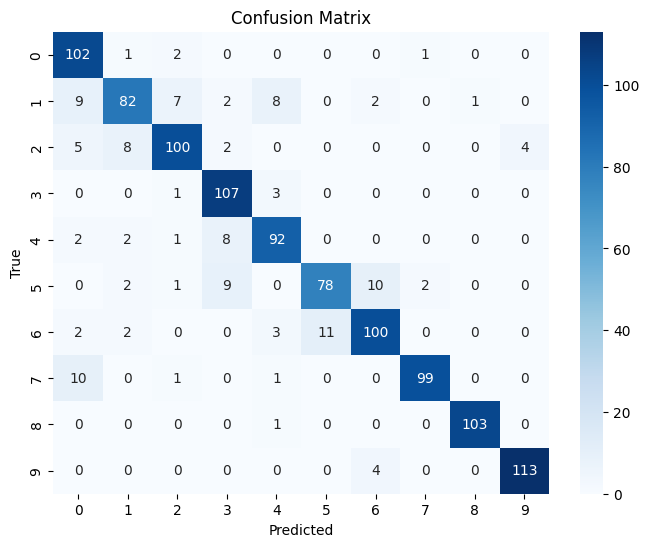

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**AUROC**

In [ ]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)

Macro-Averaged ROC-AUC Score: 99.29%


In [ ]:
model.save('tomato-leaf-disease_AlexNet_model.keras')

print("Model saved successfully!")

Model saved successfully!
